In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size + hidden_size, hidden_size)
        self.T = nn.Tanh()
        # <создать Wx, Wy?>

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        A = self.W.forward(torch.cat([input_data, hidden], 1))
        hidden = self.T(A)
        return hidden

    def init_hidden(self, bath_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([1, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]]
new_hidden:  [[-0.4534653  -0.7074053   0.5731837   0.08521792 -0.07268842]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[-0.29772812 -0.64339805  0.5685247   0.16998616 -0.2678895 ]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K May 14 18:12 MNIST


Populating the interactive namespace from numpy and matplotlib


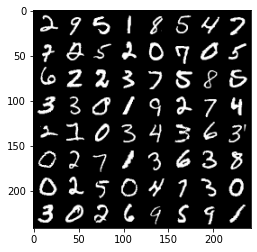

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0530,  0.0713,  0.0123,  0.1020,  0.0737,  0.0399,  0.0172, -0.0760,
         -0.1140, -0.1205],
        [ 0.0227,  0.0807,  0.0131,  0.0424,  0.0780,  0.0664,  0.0322, -0.1038,
         -0.1105, -0.1217],
        [ 0.0520,  0.0684,  0.0134,  0.1020,  0.0736,  0.0367,  0.0184, -0.0709,
         -0.1126, -0.1169],
        [ 0.0480,  0.0683,  0.0219,  0.1033,  0.0683,  0.0361,  0.0209, -0.0711,
         -0.0999, -0.1235],
        [ 0.0518,  0.0750,  0.0273,  0.1041,  0.0556,  0.0426,  0.0194, -0.0781,
         -0.0982, -0.1215],
        [ 0.0512,  0.0700,  0.0213,  0.1050,  0.0672,  0.0391,  0.0209, -0.0728,
         -0.0965, -0.1252],
        [ 0.0346,  0.0788,  0.0249,  0.1043,  0.0372,  0.0244,  0.0207, -0.0856,
         -0.1124, -0.1207],
        [ 0.0517,  0.0716,  0.0113,  0.0952,  0.0513,  0.0332,  0.0327, -0.0673,
         -0.1256, -0.1282],
        [ 0.0512,  0.0844, -0.0240,  0.0659,  0.1390,  0.0230,  0.0243, -0.1258,
         -0.1216, -0.1427],
        [ 0.0512,  

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7110 | Train Accuracy: 77.25
Epoch:  1 | Loss: 0.3010 | Train Accuracy: 91.19
Epoch:  2 | Loss: 0.2310 | Train Accuracy: 93.46
Epoch:  3 | Loss: 0.1966 | Train Accuracy: 94.44
Epoch:  4 | Loss: 0.1708 | Train Accuracy: 95.08
Epoch:  5 | Loss: 0.1528 | Train Accuracy: 95.76
Epoch:  6 | Loss: 0.1384 | Train Accuracy: 96.14
Epoch:  7 | Loss: 0.1373 | Train Accuracy: 96.12
Epoch:  8 | Loss: 0.1229 | Train Accuracy: 96.57
Epoch:  9 | Loss: 0.1174 | Train Accuracy: 96.72


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.17


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 9.17MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

ls: cannot access 'data/imdb/aclImdb/': No such file or directory


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['THE', 'VAN', 'is', 'a', 'simple', 'teensploitation', 'picture', 'made', 'especially', 'for', 'the', 'drive', 'in', 'that', 'goes', 'out', 'of', 'it', "'s", 'way', 'to', 'make', 'you', 'feel', 'comfortable', ',', 'providing', 'many', 'opportunities', 'to', 'laugh', 'and', 'cry', 'with', 'your', 'friends', '.', 'Danny', 'Devito', 'has', 'a', 'small', 'yet', 'plentiful', 'role', 'as', 'the', 'manager', 'of', 'a', 'car', 'wash', 'and', 'almost', 'steals', 'the', 'show', '!', 'All', 'the', 'leads', 'are', 'well', 'acted', ',', 'the', 'characters', 'complex', 'and', 'the', 'directing', 'quite', 'competent', 'for', 'this', 'type', 'of', 'picture', '.', 'A', 'Crown', 'International', 'Release', '.'], 'label': 'pos'}


In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202627), (',', 191383), ('.', 165682), ('a', 109305), ('and', 108923), ('of', 101047), ('to', 93345), ('is', 75851), ('in', 61216), ('I', 54394), ('it', 53362), ('that', 48990), ('"', 44734), ("'s", 43070), ('this', 42150), ('-', 37086), ('/><br', 35418), ('was', 35143), ('as', 30324), ('with', 29944)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.layer = nn.Linear(hidden_dim, output_dim)
    

        
    def forward(self, text):
          
        #text,shape = [sent len, batch size]

        embedded = self.embedding(text)

        #embedded.shape = [sent len, batch size, emb dim]
      
        output, hidden = self.rnn(embedded)        
        #output.shape = [sent len, batch size, hid dim]
        #hidden.shape = [1, batch size, hid dim]
      
       # assert torch.equal(output[-1,:,:], hidden.squeeze(0))
      
        return self.layer(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(TEXT.vocab)

# Размерность embedding
EMBEDDING_DIM = 128

# Размерность hidden:
HIDDEN_DIM = 256

OUTPUT_DIM = 1

In [ ]:
# Сама модель
import torch.optim as optim

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def accuracy(y_pred, y_true):
    preds = torch.round(torch.sigmoid(y_pred))
    ans = (preds == y_true).float()
    return ans.sum()/len(ans)

In [ ]:
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    model.train()

    for batch in train_iterator:
      
        optimizer.zero_grad()

        outputs = model(batch.text).squeeze(1)

        loss = criterion(outputs, batch.label)
        
        acc = accuracy(outputs, batch.label)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()
    train_loss = train_loss/len(train_iterator)
    train_acc = train_acc/len(train_iterator)
    print(f'Train Loss:{train_loss:.4f} | Train Accuracy:{train_acc * 100:.4f}%')

Train Loss:0.6934 | Train Accuracy:50.3397%
Train Loss:0.6934 | Train Accuracy:50.1067%
Train Loss:0.6935 | Train Accuracy:50.1238%
Train Loss:0.6934 | Train Accuracy:50.1255%
Train Loss:0.6934 | Train Accuracy:49.9992%
